# PDE-Learning of non-interacting fermions dynamics in $J_1-J_2$ model near Lifshitz critical point


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np 
sys.path.insert(0, "../")

from PDE_search import *
from utils import save_dict, load_dict
from utils import generalized_euler_solver, get_euler_term_from_descr

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# In this example we consider Hamiltonian of the fermion gas in the presence of next-nearest-neighbour hopping:
$$ H = -J_1 \sum_i (c^{+}_i c_{i+1} + c^+_{i+1} c_i)-J_2 \sum_i (c^{+}_i c_{i+2} + c^{+}_{i+2} c_i),$$
where $c^+_i$ ($c_i$) is the creation (annihilation) fermion operator, $J_{1}$ and $J_{2}$ are the nearest-neighbour and the next-neighbouring hopping coefficients, respectively. 

Fermion dispersion is $\varepsilon_k = - 2J_1 \cos{(k)} - 2 J_2 \cos{(2k)}$. In the long-wavelength limit, we can perform an expansion up to the fourth order in $k$:
$$\varepsilon_k = \varepsilon_0 + \frac{\alpha k^2}{2} + \frac{\beta k^4}{4} + \mathcal{O}(k^6),$$

where $\alpha = 2(J_1+4 J_2)$ and $\beta=-\left(\frac{J_1}{3}+\frac{16}{3}J_2\right)$.
By tuning the ratio of the hoppings $J_2/J_1$, one can set the coefficient $\alpha$ in front of the quadratic term to zero or even change the sign, while keeping $\beta$ positive.
The critical point $\alpha=0$ is a Lifshitz point where the Fermi surface changes the topology:  a single Fermi pocket at $\alpha>0$ splits into two pockets at $\alpha<0$.

In our example below we choose the following values of the hopping coefficients $J_1=-0.5$, $J_2=0.125$, that exactly corresponds to the Lifshitz point. 

## First, let's have a look at the dataset

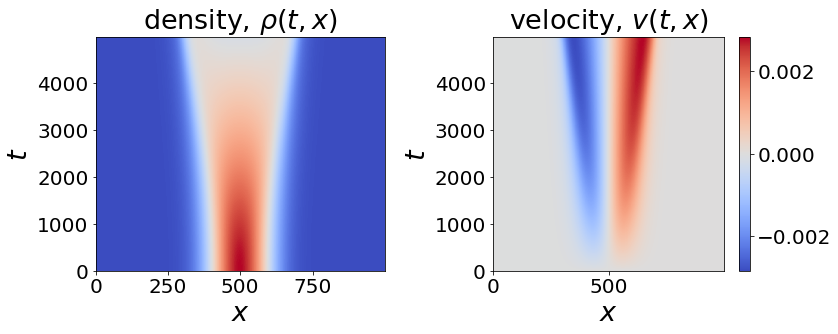

In [87]:
fname ='./data/free_fermions_J1=-0.5_J2=0.125_L=1000.npy'
data_dict = load_dict(fname)

# Density
rho = data_dict['n']
# Velocity
v = data_dict['v']

# Temporal and Spatial points
t = data_dict['t']
x = data_dict['x']

#-----------------------------------------------------------------------------
# Truncating dataset (for faster computation)
stop = 1000
rho = rho[:stop]
v = v[:stop]
t = t[:stop]
#-----------------------------------------------------------------------------
# Plot data

xx, tt = np.meshgrid(x, t)
fig, ax = plt.subplots(1, 2, figsize = (12, 5));
plt_rho = ax[0].pcolormesh(xx, tt, rho, cmap='coolwarm')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'density, $\rho(t, x)$')

plt_v = ax[1].pcolormesh(xx, tt, v, cmap='coolwarm')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'velocity, $v(t, x)$')
fig.colorbar(plt_v, ax=ax[1])

fig.tight_layout(pad=2)

In [76]:
dt = t[1]-t[0]
dx = x[1]-x[0]
m, n = rho.shape
print('Dataset dimensions: ', rho.shape)
print('Xmax, Tmax: ', x[-1], t[-1])

Dataset dimensions:  (1000, 1000)
Xmax, Tmax:  999 4995


## Preparing library of candidate terms for $\rho_t=F(...)$

In [88]:
#-----------------------------------------------------------------------------
# Define symbolic expressions for the candidate terms in rho_t=F(...)
#-----------------------------------------------------------------------------
rho_descr = [ 'rho',
              'v',
              'rho_x',
              'v_x',
              'v*v_x',
              'rho*rho_x',
              'v*rho_x',
              'rho*v_x',
              'rho*v*rho_x',
              'rho^2*v_x',    
              'rho^2*v*rho_x',
              'rho^3*v_x',    
              'rho^3*v*rho_x',
              'rho^4*v_x',  
            ]

#-----------------------------------------------------------------------------
# Define boundary conditions, needed for evaluation of spatial derivatives
bc = "periodic"
#-----------------------------------------------------------------------------

#-----------------------------------------------------------------------------
# Compute temporal and spatial derivatives and build Theta(U) matrix
rhot = TotalFiniteDiff_t(rho, dt).reshape((n*m,1))

rho_data = []
for term in rho_descr:
    rho_data.append(get_euler_term_from_descr(term, rho, v, x, bc).reshape((m*n, 1)))

rho_data = np.hstack(rho_data)
rho_Theta, rho_descr = build_custom_Theta(rho_data, rho_descr)

In [89]:
print(r"Total number of terms for rho_t=F(.):", len(rho_descr))

Total number of terms for rho_t=F(.): 14


## Search PDE for density: $\rho_t = F(...)$

In [90]:
xi_rho, _ = BruteForceL0(rho_Theta, rhot, rho_descr, l0_penalty=1e-5,
                     verbose=False, lhs_descr='rho_t')

Best PDE found with BruteForce:
rho_t = (-1.001234 +0.000000i)v*rho_x
    + (-1.000121 +0.000000i)rho*v_x
   
Time elapsed (s): 10.899804830551147


Hooray! We recovered the exact continuity equation!

## Search PDE for velocity: $v_t = G(...)$

In [92]:
#-------------------------------------------------------------------
# Define symbolic expressions for the candidate terms in v_t=G(...)
#-------------------------------------------------------------------

v_descr = [
          'rho_x',
           'v*v_x',
           'v^2*rho_x',
           'v^2*rho*rho_x',
           'v^2*rho_x*1/rho',
           'rho*v*v_x',
           'rho*rho_x', 
           'rho^2*rho_x', 
           'rho^3*rho_x',
           'rho^4*rho_x',
           'rho^5*rho_x',]

#-----------------------------------------------------------------------------
# Compute temporal derivative v_t from data
vt = TotalFiniteDiff_t(v, dt).reshape((n*m,1))

v_data = []
for term in v_descr:
    v_data.append(get_euler_term_from_descr(term, rho, v, x, bc).reshape((m*n, 1)))

v_data = np.hstack(v_data)
v_Theta, v_descr = build_custom_Theta(v_data, v_descr)

In [93]:
print(r"Total number of terms for v_t=G(.):", len(v_descr))

Total number of terms for v_t=G(.): 11


In [94]:
xi_v, _ = BruteForceL0(v_Theta, vt, v_descr, l0_penalty=1e-5,
                       verbose=False, lhs_descr='v_t')

Best PDE found with BruteForce:
v_t = (-4.941513 +0.000000i)v*v_x
    + (-227.449326 +0.000000i)rho^5*rho_x
   
Time elapsed (s): 7.308254957199097


The discovered system of equations is very close to the semiclassical equations of motion for the ideal Fermi gas with quartic dispersion $\varepsilon_k = \frac{\beta}{4} k^4$:
$$\begin{cases}
\rho_t+(\rho v)_x = 0,\\
v_t + 5 v v_x - v^2\frac{\rho_x}{\rho} + \beta^2 \pi^6 \rho^5 \rho_x = 0, 
\end{cases}
$$
where $\beta=0.5$ (that corresponds to the choice of the values of the hopping coefficients $J_1=-0.5$, $J_2=0.125$).

## Now we solve the inferred hydrodynamic PDE

In [96]:
rho_ev, v_ev = generalized_euler_solver(v_descr, xi_v.real, 
                                        rho[0], v[0], t, x, 
                                        num_integrator_steps=25)

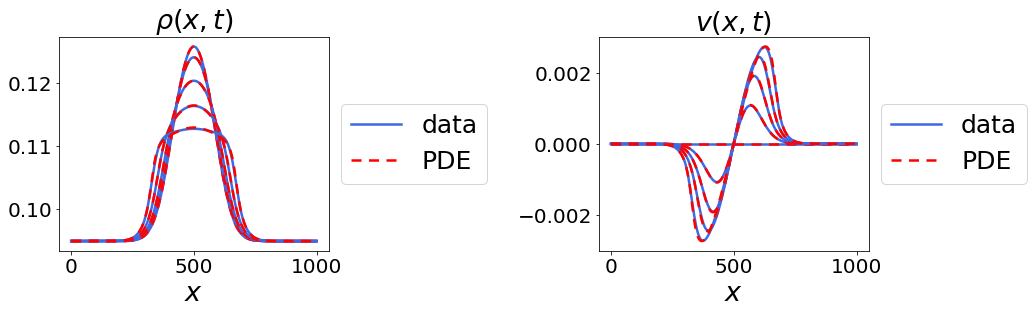

In [104]:
time_points = [0, 200, 400, 600, 800]
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
for i, indx in enumerate(time_points):
    if i == 0:
        label1, label2 = 'data', 'PDE'
    else:
        label1, label2 = '', ''
    ax[0].plot(x, rho[indx, :],
             c='royalblue', label=label1)
    ax[0].plot(x, rho_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)

    ax[1].plot(x, v[indx, :],
             c='royalblue', label=label1)
    ax[1].plot(x, v_ev[indx,:], 
             ls='--', c='red', dashes=(4,3), label=label2)

ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_xlabel(r'$x$')
ax[0].set_title(r'$\rho(x, t)$')

ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_xlabel(r'$x$')
ax[1].set_title(r'$v(x, t)$')

fig.tight_layout(pad=3)

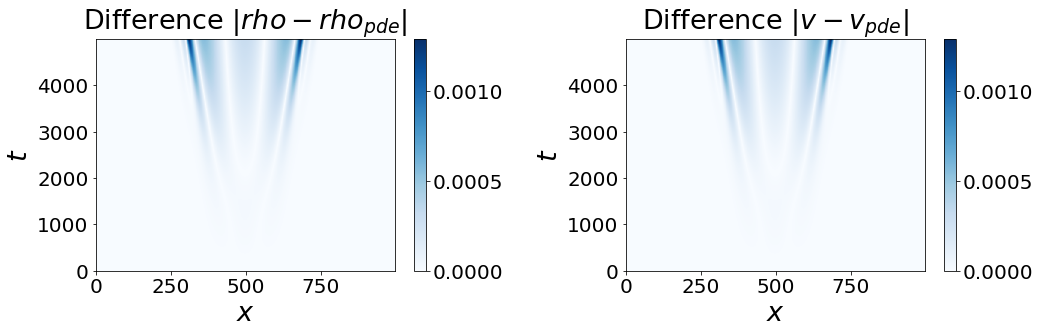

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
plt_rho = ax[0].pcolormesh(xx, tt, abs(rho-rho_ev), cmap='Blues', rasterized=True)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$t$')
ax[0].set_title(r'Difference $|rho-rho_{pde}|$')
fig.colorbar(plt_rho, ax=ax[0])

plt_v = ax[1].pcolormesh(xx, tt, abs(rho-rho_ev), cmap='Blues', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'Difference $|v-v_{pde}|$')
fig.colorbar(plt_v, ax=ax[1])
fig.tight_layout(pad=2)